# Domain matches BN

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import csv
import networkx as nx
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

### Matches

In [3]:
op = gaffer.GetAllElements(entities=None, edges=["matches"])
r = g.execute_chunked(op)

matches = {}

for v in r:

    try:
        obj = json.loads(v)
    except:
        # Ignore lines which don't parse as JSON
        continue

    src = obj["source"]
    dest = obj["destination"]
    
    if not src in matches:
        matches[src] = []
    matches[src].append({
        "blacklist": dest,
        "latest": obj["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["latest"]
    })

r.close()

matches

{'141.0.176.21': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1528488000.0},
  {'blacklist': 'apility.UCEPROTECT-LEVEL1', 'latest': 1528488000.0}],
 '141.101.11.89': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1529496000.0},
  {'blacklist': 'apility.UCEPROTECT-LEVEL1', 'latest': 1529496000.0}],
 '141.101.244.9': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1530691200.0}],
 '141.105.66.163': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1528488000.0},
  {'blacklist': 'vt.61c67b697d0577ff172232fa6f0b343c7de78f9d0cf14e06037ee675814c04a6',
   'latest': 1524560400.0}],
 '141.126.209.37': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1530691200.0}],
 '141.134.27.231': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1528488000.0}],
 '141.134.46.26': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1529496000.0},
  {'blacklist': 'apility.UCEPROTECT-LEVEL1', 'latest': 1529496000.0}],
 '141.13

### Domains

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()
all_timestamps = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)
    all_timestamps.update(ts)
    
res.close()

In [5]:
print(len(all_timestamps))

1001


In [6]:
all_devices = list(all_devices)
all_things = list(all_things)

## Top domains

In [7]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,simon-macpro,misskitty-mac,calcannea-android,calcannea-mac,languid-mac,nervings-cb,dramatic-mac,turing-macbook,boundless-mac,MalcomWare-PC,...,turing-minimacbook,theatergoing-mac,raymond-mac,essential-mac,steamverne-mac,traverses-mac,DESKTOP-PIMD8C0,LAPTOP-1I501C4U,castle3b7c9f,score
dondash.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
re-scrape.com,0,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
patreon.com,0,4,0,0,0,0,28,0,0,0,...,0,0,0,0,0,0,0,0,0,48
baidu.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
oracle.com,0,36,0,0,1,13,0,0,18,0,...,0,1,2,0,0,0,0,0,0,101
1plus.io,0,0,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
aolcdn.com,0,6,0,0,1,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,26
rtclx.com,0,0,0,0,1,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,7
chimpstatic.com,0,4,0,0,1,0,0,0,3,0,...,4,2,1,0,2,0,0,0,0,24
wp.com,0,892,0,6,13,25,39,0,73,0,...,13,6,45,0,107,2,6,6,0,1473


In [8]:
num_domains = 1000
top_domains = df.sort_values(by="score", ascending=False).index.values[:num_domains]
top_domains

array(['google.com', 'gstatic.com', 'googleapis.com', 'apple.com',
       'in-addr.arpa', 'trustnetworks.com', 'clubhouse.io',
       'doubleclick.net', 'akadns.net', 'netgear.com', 'amazonaws.com',
       'slack.com', 'googleusercontent.com', 'github.com',
       'akamaiedge.net', 'microsoft.com', 'facebook.com', 'google.co.uk',
       'apple-dns.net', 'icloud.com', 'fedoraproject.org', 'amazon.com',
       'google-analytics.com', 'rbxcdn.com', 'virustotal.com',
       'bbc.co.uk', 'cloudapp.net', 'cloudfront.net', 'utun1.viscosity',
       'ea.com', 'codeanywhere.com', 'adnxs.com', 'adsafeprotected.com',
       'utun2.viscosity', 'skype.com', 'githubusercontent.com',
       'slack-edge.com', 'intercom.io', 'googlesyndication.com',
       'hubspot.com', 'linkedin.com', 'fastly.net', 'bbci.co.uk',
       'slack-msgs.com', 'ddns.net', 'imrworldwide.com', 'cymru.com',
       'pubmatic.com', 'twitter.com', 'utun10.viscosity', 'gravatar.com',
       'quantserve.com', 'trafficmanager.net', 

## Selected domains

In [9]:
selected=top_domains[:20]
selected

array(['google.com', 'gstatic.com', 'googleapis.com', 'apple.com',
       'in-addr.arpa', 'trustnetworks.com', 'clubhouse.io',
       'doubleclick.net', 'akadns.net', 'netgear.com', 'amazonaws.com',
       'slack.com', 'googleusercontent.com', 'github.com',
       'akamaiedge.net', 'microsoft.com', 'facebook.com', 'google.co.uk',
       'apple-dns.net', 'icloud.com'], dtype=object)

## Rework as matrix

In [10]:
datas = []

for ts in all_timestamps:
    for dev in all_devices:
        row = [dev, ts]
        for thing in selected:
            val = False
            k = (dev, thing)
            if k in timestamps:
                if ts in timestamps[k]:
                    val = True
            row.append(val)
        datas.append(row)

In [11]:
cols = ["device", "time"]
cols.extend(selected)
cols

['device',
 'time',
 'google.com',
 'gstatic.com',
 'googleapis.com',
 'apple.com',
 'in-addr.arpa',
 'trustnetworks.com',
 'clubhouse.io',
 'doubleclick.net',
 'akadns.net',
 'netgear.com',
 'amazonaws.com',
 'slack.com',
 'googleusercontent.com',
 'github.com',
 'akamaiedge.net',
 'microsoft.com',
 'facebook.com',
 'google.co.uk',
 'apple-dns.net',
 'icloud.com']

In [12]:
df = pd.DataFrame(datas, columns = cols)
df = df.set_index(["device", "time"])

In [13]:
df

,,google.com,gstatic.com,googleapis.com,apple.com,in-addr.arpa,trustnetworks.com,clubhouse.io,doubleclick.net,akadns.net,netgear.com,amazonaws.com,slack.com,googleusercontent.com,github.com,akamaiedge.net,microsoft.com,facebook.com,google.co.uk,apple-dns.net,icloud.com
device,time,,,,,,,,,,,,,,,,,,,,
simon-macpro,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
misskitty-mac,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
calcannea-android,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
calcannea-mac,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
languid-mac,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
nervings-cb,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
dramatic-mac,1.531238e+09,True,True,True,True,True,False,False,True,True,False,True,False,True,False,True,False,False,False,True,True
turing-macbook,1.531238e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
boundless-mac,1.531238e+09,True,True,True,True,True,True,True,True,True,False,True,True,True,False,False,False,True,True,False,False


In [14]:
csvcols = list(df.columns)
csvmap = {csvcols[v]: v for v in range(len(csvcols))}

with open('domains.csv', 'w') as csvfile:
    csvwriter = csv.DictWriter(csvfile, fieldnames=csvcols)
    csvwriter.writeheader()
    for ix, row in df[:1000].iterrows():
        row = [1 if v else 0 for v in list(row)]
        r = {}
        for i in range(len(list(row))):
            r[df.columns[i]] = row[i]
        csvwriter.writerow(r)
            

In [15]:
csvmap

{'akadns.net': 8,
 'akamaiedge.net': 14,
 'amazonaws.com': 10,
 'apple-dns.net': 18,
 'apple.com': 3,
 'clubhouse.io': 6,
 'doubleclick.net': 7,
 'facebook.com': 16,
 'github.com': 13,
 'google.co.uk': 17,
 'google.com': 0,
 'googleapis.com': 2,
 'googleusercontent.com': 12,
 'gstatic.com': 1,
 'icloud.com': 19,
 'in-addr.arpa': 4,
 'microsoft.com': 15,
 'netgear.com': 9,
 'slack.com': 11,
 'trustnetworks.com': 5}

## Bayesian network analysis

In [16]:
bdeu = BdeuScore(df, equivalent_sample_size=5)
k2 = K2Score(df)
bic = BicScore(df)

In [17]:
model1 = BayesianModel([('google.com', 'gstatic.com'), ('google.com', 'googleapis.com')])
model2 = BayesianModel([('google.com', 'gstatic.com'), ('googleapis.com', 'google.com')])

In [18]:
print(bdeu.local_score('google.com', parents=[]))

-11855.52541098453


In [19]:
print(bdeu.local_score('google.com', parents=['googleapis.com']))

0.0


In [20]:
from pgmpy.estimators import HillClimbSearch

In [21]:
hc = HillClimbSearch(df, scoring_method=BicScore(df))
best_model = hc.estimate()
print(best_model.edges())

[('google.com', 'slack.com'), ('trustnetworks.com', 'icloud.com'), ('trustnetworks.com', 'github.com'), ('doubleclick.net', 'googleapis.com'), ('doubleclick.net', 'clubhouse.io'), ('akadns.net', 'in-addr.arpa'), ('akadns.net', 'google.co.uk'), ('netgear.com', 'trustnetworks.com'), ('amazonaws.com', 'gstatic.com'), ('amazonaws.com', 'doubleclick.net'), ('slack.com', 'microsoft.com'), ('googleusercontent.com', 'google.com'), ('github.com', 'googleusercontent.com'), ('akamaiedge.net', 'akadns.net'), ('facebook.com', 'apple-dns.net'), ('facebook.com', 'akamaiedge.net'), ('apple-dns.net', 'apple.com'), ('apple-dns.net', 'amazonaws.com'), ('icloud.com', 'facebook.com')]


In [22]:
hc = HillClimbSearch(df[:1000], scoring_method=BicScore(df))
%time best_model = hc.estimate()
print(best_model.edges())

CPU times: user 4min 37s, sys: 3.91 s, total: 4min 41s
Wall time: 5min 1s
[('google.com', 'slack.com'), ('trustnetworks.com', 'icloud.com'), ('trustnetworks.com', 'github.com'), ('doubleclick.net', 'googleapis.com'), ('doubleclick.net', 'clubhouse.io'), ('akadns.net', 'in-addr.arpa'), ('akadns.net', 'google.co.uk'), ('netgear.com', 'trustnetworks.com'), ('amazonaws.com', 'gstatic.com'), ('amazonaws.com', 'doubleclick.net'), ('slack.com', 'microsoft.com'), ('googleusercontent.com', 'google.com'), ('github.com', 'googleusercontent.com'), ('akamaiedge.net', 'akadns.net'), ('facebook.com', 'apple-dns.net'), ('facebook.com', 'akamaiedge.net'), ('apple-dns.net', 'apple.com'), ('apple-dns.net', 'amazonaws.com'), ('icloud.com', 'facebook.com')]


In [23]:
g = nx.DiGraph()

In [24]:
for v in best_model.edges():
    g.add_edge(*v)

In [25]:
g.edges()

[('google.com', 'slack.com'),
 ('slack.com', 'microsoft.com'),
 ('trustnetworks.com', 'icloud.com'),
 ('trustnetworks.com', 'github.com'),
 ('icloud.com', 'facebook.com'),
 ('github.com', 'googleusercontent.com'),
 ('doubleclick.net', 'googleapis.com'),
 ('doubleclick.net', 'clubhouse.io'),
 ('akadns.net', 'in-addr.arpa'),
 ('akadns.net', 'google.co.uk'),
 ('netgear.com', 'trustnetworks.com'),
 ('amazonaws.com', 'gstatic.com'),
 ('amazonaws.com', 'doubleclick.net'),
 ('googleusercontent.com', 'google.com'),
 ('akamaiedge.net', 'akadns.net'),
 ('facebook.com', 'apple-dns.net'),
 ('facebook.com', 'akamaiedge.net'),
 ('apple-dns.net', 'apple.com'),
 ('apple-dns.net', 'amazonaws.com')]

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/lib64/python3.6/site-packages/matplotlib/__init__.py:920: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/lib64/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


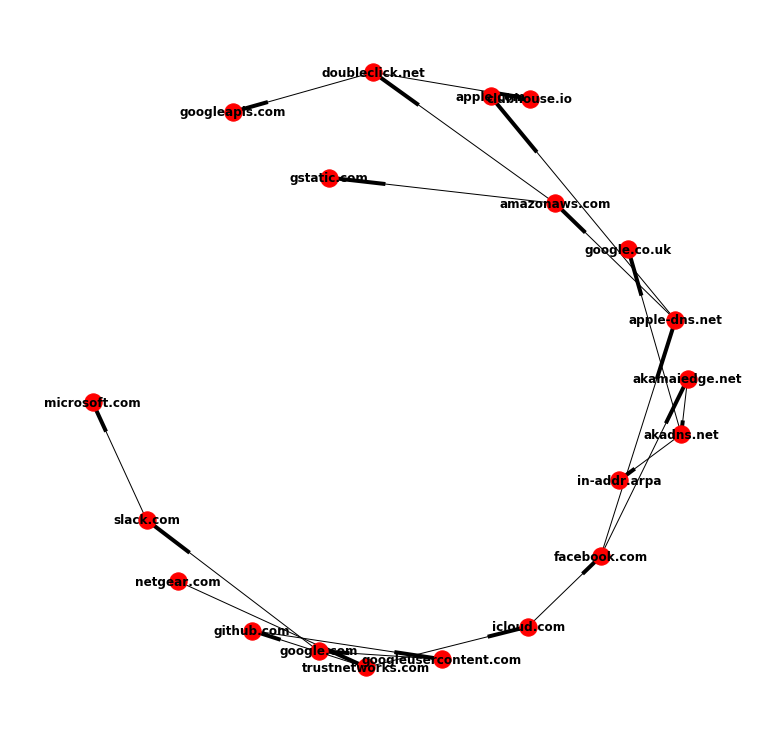

In [26]:
plt.figure(figsize=(10,10))
nx.draw(g, with_labels=True, font_weight='bold')
plt.show()

In [27]:
nx.nx_agraph.write_dot(g, "domains.dot")